# Aiida

## Define workflow with aiida

In [1]:
from python_workflow_definition.aiida import write_workflow_json
from python_workflow_definition.shared import get_dict, get_list

from aiida import load_profile, orm

load_profile()

workflow_json_filename = "aiida_qe.json"

In [2]:
from aiida_workgraph import task, WorkGraph

In [3]:
from quantum_espresso_workflow import generate_structures
from quantum_espresso_workflow import get_bulk_structure
from quantum_espresso_workflow import calculate_qe as _calculate_qe
from quantum_espresso_workflow import plot_energy_volume_curve

In [4]:
calculate_qe = task(outputs=["energy", "volume", "structure"])(_calculate_qe)

In [5]:
wg = WorkGraph("wg-qe")

### Prepare the inputs

In [6]:
element = orm.Str("Au")
a = orm.Float(4.05)
cubic = orm.Bool(True)
relax_workdir = orm.Str("mini")
pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
kpts = orm.List([3, 3, 3])
calc_type_relax = orm.Str("vc-relax")
calc_type_scf = orm.Str("scf")
smearing = orm.Float(0.02)
strain_lst = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])

### Actual tasks to construct the EOS workflow

In [7]:
get_bulk_structure_task = wg.add_task(
    get_bulk_structure,
    name="get_bulk_structure",
    element=element,
    a=a,
    cubic=cubic,
)

In [8]:
relax_prepare_input_dict_task = wg.add_task(
    get_dict,
    name="relax_get_dict",
    structure=get_bulk_structure_task.outputs.result,
    calculation=calc_type_relax,
    kpts=kpts,
    pseudopotentials=pseudopotentials,
    smearing=smearing,
)

relax_task = wg.add_task(
    calculate_qe,
    name="mini",
    input_dict=relax_prepare_input_dict_task.outputs.result,
    working_directory=relax_workdir,
)

In [9]:
generate_structures_task = wg.add_task(
    generate_structures,
    name="generate_structures",
    structure=relax_task.outputs.structure,
    strain_lst=strain_lst,
)

In [10]:
get_volumes_task = wg.add_task(get_list, name="get_volumes")

In [11]:
get_energies_task = wg.add_task(get_list, name="get_energies")

In [12]:
strain_dir_tasks, scf_qe_tasks, scf_get_dict_tasks = [], [], []

for i, strain in enumerate(strain_lst):

    structure_key = f"s_{i}"
    strain_dir = orm.Str(f"strain_{i}")
    generate_structures_task.add_output("workgraph.any", structure_key)

    scf_prepare_input_dict_task = wg.add_task(
        get_dict,
        name=f"get_dict_{i}",
        structure=generate_structures_task.outputs[structure_key],
        calculation=calc_type_scf,
        kpts=kpts,
        pseudopotentials=pseudopotentials,
        smearing=smearing,
    )

    scf_qe_task = wg.add_task(
        calculate_qe,
        name=f"qe_{i}",
        input_dict=scf_prepare_input_dict_task.outputs.result,
        working_directory=strain_dir,
    )

    # collect energy and volume
    get_energies_task.set({f"{i}": scf_qe_task.outputs.energy})
    get_volumes_task.set({f"{i}": scf_qe_task.outputs.volume})

In [13]:
plot_energy_volume_curve_task = wg.add_task(
    plot_energy_volume_curve,
    name="plot_energy_volume_curve",
    volume_lst=get_volumes_task.outputs.result,
    energy_lst=get_energies_task.outputs.result,
)

In [14]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-qe',…

In [15]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [16]:
!cat {workflow_json_filename}

{
  "nodes": [
    {
      "id": 0,
      "function": "quantum_espresso_workflow.get_bulk_structure"
    },
    {
      "id": 1,
      "function": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 2,
      "function": "quantum_espresso_workflow.calculate_qe"
    },
    {
      "id": 3,
      "function": "quantum_espresso_workflow.generate_structures"
    },
    {
      "id": 4,
      "function": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 5,
      "function": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 6,
      "function": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 7,
      "function": "quantum_espresso_workflow.calculate_qe"
    },
    {
      "id": 8,
      "function": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 9,
      "function": "quantum_espresso_workflow.calculate_qe"
    },
    {
      "id": 10,
      "function": "python_workflow_definition.shared.get_dic

## Load Workflow with jobflow

In [17]:
from python_workflow_definition.jobflow import load_workflow_json

/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [18]:
from jobflow.managers.local import run_locally

In [19]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [20]:
flow[0].function_kwargs["element"] = "Al"

2025-04-13 12:55:44,792 INFO Started executing jobs locally
2025-04-13 12:55:45,039 INFO Starting job - get_bulk_structure (e1a11480-bb1e-43b0-8624-6f33bc89ea83)
2025-04-13 12:55:45,043 INFO Finished job - get_bulk_structure (e1a11480-bb1e-43b0-8624-6f33bc89ea83)
2025-04-13 12:55:45,044 INFO Starting job - get_dict (08adf252-b77d-4358-ab85-f465d3a8dbcb)
2025-04-13 12:55:45,045 INFO Finished job - get_dict (08adf252-b77d-4358-ab85-f465d3a8dbcb)
2025-04-13 12:55:45,045 INFO Starting job - calculate_qe (97dd621c-a31f-4b2b-a48a-4e11a0e513a5)


[jupyter-pyiron-dev-pyth-flow-definition-fb3hox7q:00338] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-13 12:56:36,278 INFO Finished job - calculate_qe (97dd621c-a31f-4b2b-a48a-4e11a0e513a5)
2025-04-13 12:56:36,279 INFO Starting job - generate_structures (09d03c9c-b4c7-4f80-a0bc-e358960f282a)
2025-04-13 12:56:36,283 INFO Finished job - generate_structures (09d03c9c-b4c7-4f80-a0bc-e358960f282a)
2025-04-13 12:56:36,284 INFO Starting job - get_dict (26e6f6a3-9de0-48cf-9fd2-b26d989f3df9)
2025-04-13 12:56:36,285 INFO Finished job - get_dict (26e6f6a3-9de0-48cf-9fd2-b26d989f3df9)
2025-04-13 12:56:36,286 INFO Starting job - get_dict (b538b941-bf0c-4116-8c0c-e0c2fdb2a58b)
2025-04-13 12:56:36,287 INFO Finished job - get_dict (b538b941-bf0c-4116-8c0c-e0c2fdb2a58b)
2025-04-13 12:56:36,288 INFO Starting job - get_dict (ad9c9fd4-14b9-4c0c-8067-9de86caf0c39)
2025-04-13 12:56:36,289 INFO Finished job - get_dict (ad9c9fd4-14b9-4c0c-8067-9de86caf0c39)
2025-04-13 12:56:36,290 INFO Starting job - get_dict (3bd2c1a7-3d84-4684-84f7-493b7fab7f17)
2025-04-13 12:56:36,291 INFO Finished job - get_dict (

[jupyter-pyiron-dev-pyth-flow-definition-fb3hox7q:00353] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-13 12:56:46,341 INFO Finished job - calculate_qe (f89e4d75-1825-483c-8722-2524b85f1b70)
2025-04-13 12:56:46,343 INFO Starting job - calculate_qe (41fe9993-9034-4c7f-b234-f1b62e907a60)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-fb3hox7q:00364] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-13 12:56:58,627 INFO Finished job - calculate_qe (41fe9993-9034-4c7f-b234-f1b62e907a60)
2025-04-13 12:56:58,628 INFO Starting job - calculate_qe (42715c7e-e51d-48a5-8320-cb47c8fbd73f)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-fb3hox7q:00375] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-13 12:57:10,452 INFO Finished job - calculate_qe (42715c7e-e51d-48a5-8320-cb47c8fbd73f)
2025-04-13 12:57:10,453 INFO Starting job - calculate_qe (f968d564-6a41-4a67-b4ba-87cad9cb55d2)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-fb3hox7q:00386] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-13 12:57:24,083 INFO Finished job - calculate_qe (f968d564-6a41-4a67-b4ba-87cad9cb55d2)
2025-04-13 12:57:24,084 INFO Starting job - calculate_qe (4e6d70a3-4f2c-4ba2-bea6-253e972fb3da)


[jupyter-pyiron-dev-pyth-flow-definition-fb3hox7q:00397] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-13 12:57:37,473 INFO Finished job - calculate_qe (4e6d70a3-4f2c-4ba2-bea6-253e972fb3da)
2025-04-13 12:57:37,473 INFO Starting job - get_list (a9430d96-f5ff-4a42-b2f2-4dfe7eaa547d)
2025-04-13 12:57:37,476 INFO Finished job - get_list (a9430d96-f5ff-4a42-b2f2-4dfe7eaa547d)
2025-04-13 12:57:37,477 INFO Starting job - get_list (c32584a3-b67f-4372-ada8-dbfba9c0569e)
2025-04-13 12:57:37,479 INFO Finished job - get_list (c32584a3-b67f-4372-ada8-dbfba9c0569e)
2025-04-13 12:57:37,480 INFO Starting job - plot_energy_volume_curve (d2370cc2-2896-458a-94e8-383d90ebb8d8)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-13 12:57:37,557 INFO Finished job - plot_energy_volume_curve (d2370cc2-2896-458a-94e8-383d90ebb8d8)
2025-04-13 12:57:37,557 INFO Finished executing jobs locally


{'e1a11480-bb1e-43b0-8624-6f33bc89ea83': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

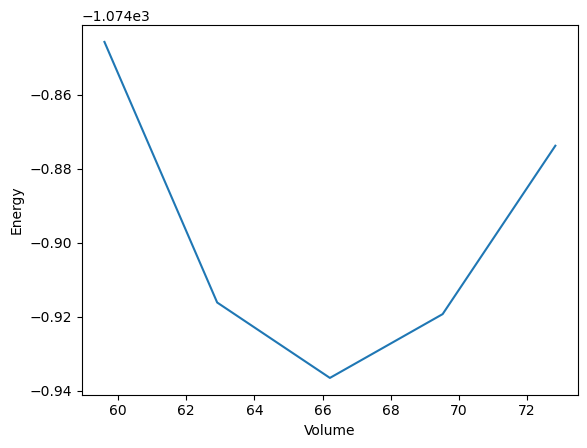

In [21]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [22]:
from pyiron_base import Project

In [23]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [24]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

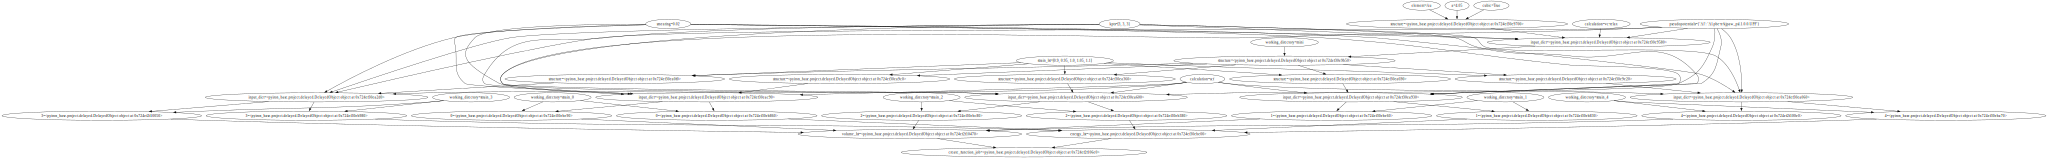

In [25]:
delayed_object_lst = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [26]:
delayed_object_lst[0]._input['kwargs']['element'] = "Al"

The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 1
The job get_dict_20400c1655d51731f9f5ffb50c2b401f was saved and received the ID: 2
The job calculate_qe_22b5d0934d89d8f08761e744e4612c30 was saved and received the ID: 3


[jupyter-pyiron-dev-pyth-flow-definition-fb3hox7q:00430] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_19ea8c3e8879449907732fcd8527bbcc was saved and received the ID: 4
The job get_dict_5411ee42b8b3c23105c22d0153a14e69 was saved and received the ID: 5
The job calculate_qe_5ebd757a1f505567feedfade01c23f87 was saved and received the ID: 6


[jupyter-pyiron-dev-pyth-flow-definition-fb3hox7q:00449] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_6d6c206aab2f0bed3f3b7992449730c2 was saved and received the ID: 7
The job calculate_qe_a18df3bc2eb3acc55a8e62c359dd1f6b was saved and received the ID: 8


[jupyter-pyiron-dev-pyth-flow-definition-fb3hox7q:00460] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_c4179f543c959b4312e9aebe77225748 was saved and received the ID: 9
The job calculate_qe_8073ad6d02c10d00f7f7ebb0b8d3a762 was saved and received the ID: 10


[jupyter-pyiron-dev-pyth-flow-definition-fb3hox7q:00472] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_7c01955b57bc7280b5b00d27812af72a was saved and received the ID: 11
The job calculate_qe_aebded4e5cfe801341696685c74e3527 was saved and received the ID: 12


[jupyter-pyiron-dev-pyth-flow-definition-fb3hox7q:00483] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_8f706596cd161dbeb4e49e8998a7b895 was saved and received the ID: 13
The job calculate_qe_f7b0e69a2d675504a719745eb8154afe was saved and received the ID: 14


[jupyter-pyiron-dev-pyth-flow-definition-fb3hox7q:00494] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_5d2e404624b12c3bb1f93528d1b1dddb was saved and received the ID: 15
The job get_list_ffc83349bacad145dcd941e78ed025fc was saved and received the ID: 16
The job plot_energy_volume_curve_3a50f3584b305adea399d6ac284412ac was saved and received the ID: 17


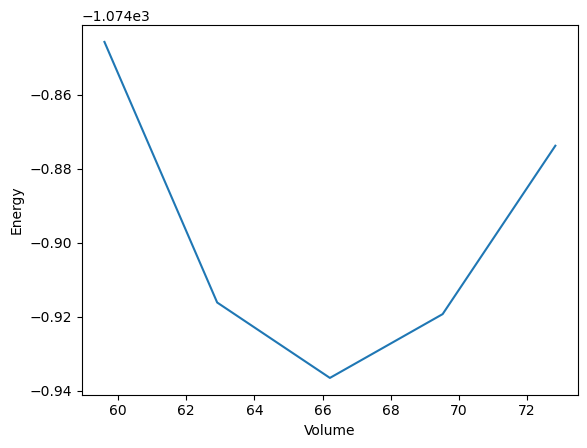

In [27]:
delayed_object_lst[-1].pull()